In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))
from support.mecanum_calculations import *
from support.pd_support import *
from tqdm import tqdm

In [120]:
_folder_name = "sk21_sideways_t0"
_parent_folder = "cam_and_sensor_feb_1_2023_5cm"

_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, 'recording_programs', "test_data")

_recorded_folder_list = os.listdir(os.path.join(_base_pth, _parent_folder))
_txt_pth = os.path.join(_base_pth, _parent_folder,"00_analysis", "folder_list.txt")

In [111]:
# with open(_txt_pth, "w") as f:
#     for i in _recorded_folder_list:
#         f.write(i + "\n")


In [121]:
with open(_txt_pth, "r") as f:
    _recorded_folder_list = f.read().splitlines()

# _recorded_folder_list = [i for i in _recorded_folder_list if i != "00_analysis" and i != _folder_name.split("_")[0]] 
# _recorded_folder_list

In [130]:
mean_err_df = pd.DataFrame(columns=["folder_name","err_x", "err_y", 
                                    "max_err_x", "max_err_y", 
                                    "std_err_x", "std_err_y", 
                                    "offset_x", "offset_y","direction",])

In [131]:
for _folder_name in tqdm(_recorded_folder_list):
    _sensor_pth = os.path.join(_base_pth, _parent_folder,_folder_name, "imu01.csv")
    _mc_pth = os.path.join(_base_pth, _parent_folder,_folder_name.split("_")[0],_folder_name + ".csv")
    sk_df = pd.read_csv(_sensor_pth)
    mc_df, st_time = read_rigid_body_csv(_mc_pth)
    mc_df = add_datetime_col(mc_df, st_time,_name="seconds")
    sk_df = add_datetime_diff(sk_df, st_time,"sync", "mils", True)
    sk_df["time"] = sk_df["time"]
    sk_df = sk_df.reset_index(drop=True)
    sk_df, mc_df = trunkate_dfs(sk_df, mc_df, False)
    radius = 47.5/1000
    lx = 79 #half of the distance between the wheels
    ly = 122.5/2

    _sk_df = set_zero(sk_df)
    _sk_df, _ang_column = get_angular_velocity(_sk_df)
    _sk_df, _ = get_directional_velocity(_sk_df, _ang_column, radius, lx, ly)
    _sk_df, _ = get_position(_sk_df)
    _sk_df["sys_time"] = pd.to_datetime(_sk_df["sys_time"])

    _cart_df = _sk_df[["time", "x_val", "y_val"]]
    _cart_df = _cart_df.rename(columns={"x_val": "x", "y_val": "y"})
    _mocap_df = mc_df[["time", "m1_z", "m1_x"]]
    _mocap_df = _mocap_df.rename(columns={"m1_z": "x", "m1_x": "y"})
    _cart_df = interpolate_target_df(_cart_df, _mocap_df, col_names=["x", "y"])

    _offset_x = _mocap_df["x"].iloc[0] - _cart_df["x"].iloc[0]
    _offset_y = _mocap_df["y"].iloc[0] - _cart_df["y"].iloc[0]
    _cart_df["x"] = _cart_df["x"] + _offset_x
    _cart_df["y"] = _cart_df["y"] + _offset_y

    
    error_df = pd.DataFrame()
    error_df["time"] = _mocap_df["time"]
    error_df["x"] = _mocap_df["x"] - _cart_df["x"]
    error_df["y"] = _mocap_df["y"] - _cart_df["y"]

    mean_err_df = mean_err_df.append({"folder_name": _folder_name, "direction": _folder_name.split("_")[2],
                                    "err_x": error_df["x"].mean(), "err_y": error_df["y"].mean(),
                                    "max_err_x": error_df["x"].max(), "max_err_y": error_df["y"].max(), 
                                    "std_err_x": error_df["x"].std(), "std_err_y": error_df["y"].std(),
                                    "offset_x": _offset_x, "offset_y": _offset_y, "speed": _folder_name.split("_")[3]}, ignore_index=True)

100%|██████████| 22/22 [00:09<00:00,  2.28it/s]


In [132]:
mean_err_df

,folder_name,err_x,err_y,max_err_x,max_err_y,std_err_x,std_err_y,offset_x,offset_y,direction,speed
0,sk23_30_forward_fast,-0.008188,-0.050827,0.007719,0.008632,0.007238,0.033724,0.102850,-0.109012,forward,fast
1,sk23_30_forward_fast_2,-0.006079,-0.008588,0.003097,0.011597,0.005060,0.011785,0.074313,-0.103652,forward,fast
2,sk23_30_forward_medium,-0.007665,-0.017345,0.002613,0.000033,0.005553,0.010974,0.122331,-0.109634,forward,medium
3,sk23_30_forward_medium_2,-0.003754,-0.016853,0.002937,0.001105,0.003536,0.012566,0.116119,-0.120307,forward,medium
4,sk23_30_forward_slow,-0.003503,0.004235,0.002385,0.018797,0.002785,0.006005,0.105094,-0.116469,forward,slow
5,sk23_30_forward_slow_2,0.000495,-0.004479,0.007811,0.002473,0.002686,0.004364,0.023015,-0.109797,forward,slow
6,sk23_30_random_fast,0.098707,-0.044085,0.402217,0.111787,0.177544,0.049609,0.106217,-0.090610,random,fast
7,sk23_30_random_fast_2,0.209153,-0.125079,0.456820,0.161993,0.175427,0.116584,0.118111,-0.100259,random,fast
8,sk23_30_random_medium,0.500360,-0.207523,1.329907,0.050286,0.459207,0.170313,0.124266,-0.110327,random,medium
9,sk23_30_random_medium_2,0.147543,-0.076715,0.434192,0.086082,0.198942,0.072892,0.104399,-0.079909,random,medium


In [133]:
mean_err_df.to_csv(os.path.join(_base_pth, _parent_folder,"00_analysis", "mean_err_df_mecanum_sk23.csv"), index=False)

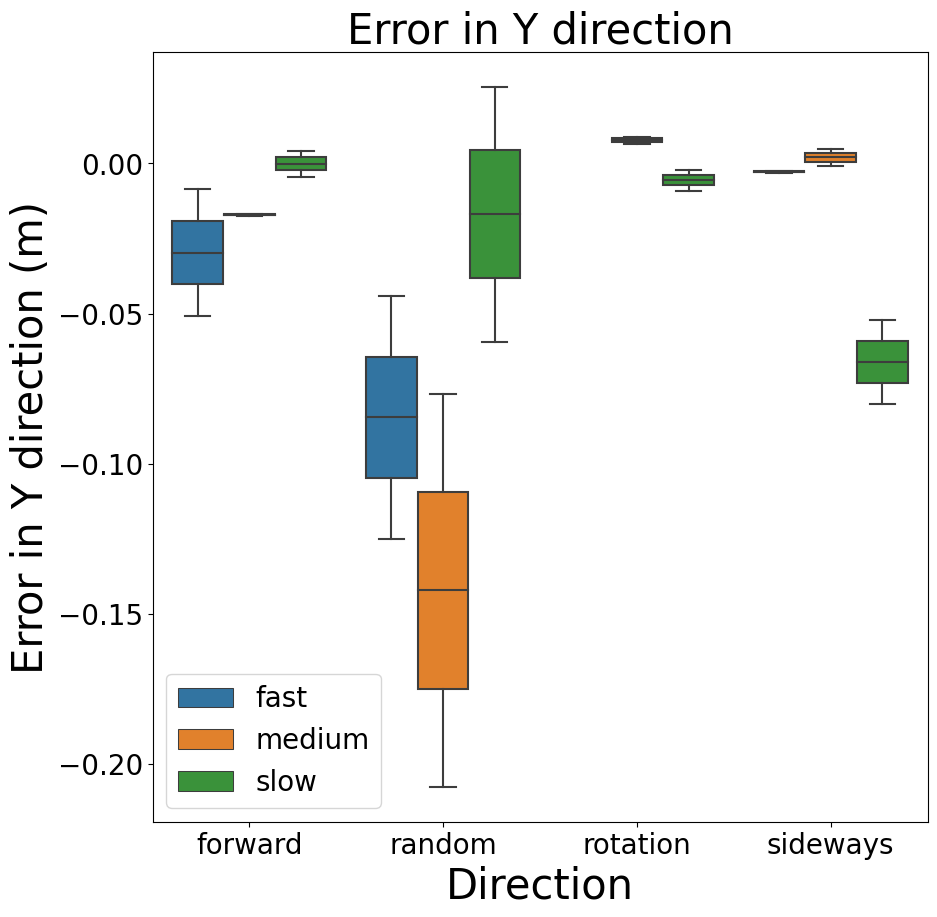

In [136]:
# box plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x="direction", y="err_y", hue="speed", data=mean_err_df, ax=ax)
ax.set_title("Error in Y direction", fontsize=30)
ax.set_xlabel("Direction", fontsize=30)
ax.set_ylabel("Error in Y direction (m)", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=20)
plt.show()